In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam


from google.colab import drive
drive.mount('/content/drive')


# Define data directories
train_dir = 'drive/MyDrive/images/train'
validation_dir = 'drive/MyDrive/images/test'

# Define parameters
batch_size = 32
image_size = (224, 224)
num_classes = 5  # Change this according to your dataset

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Normalization for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators with a limit of 1000 images per class
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Specify the subset for training data
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
)

# Load pre-trained DenseNet model (weights are downloaded automatically)
base_model = DenseNet121(weights='imagenet', include_top=False)

# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define new model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit_generator(
    train_generator,
    steps_per_epoch=min(1000, len(train_generator)),  # Limit to 1000 images per class
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Save the model
model.save('pretrained_densenet_model.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 24422 images belonging to 5 classes.
Found 5937 images belonging to 5 classes.


<ipython-input-4-a47b1679b7cc>:75: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
  6/764 [..............................] - ETA: 4:31:42 - loss: 2.2732 - accuracy: 0.2396

KeyboardInterrupt: 

original image is of neutral
1/1 [==============================] - 0s 181ms/step
model prediction is  happy


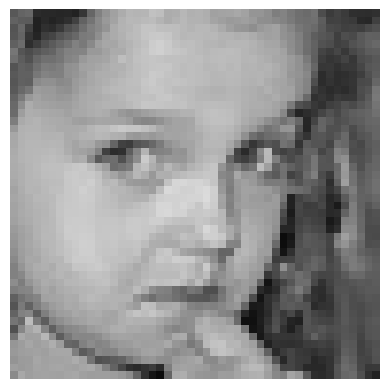

In [10]:
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt


# Define labels
label = ['angry', 'happy', 'neutral', 'sad', 'surprise']

# Function to extract features from image
# Function to extract features from image
def ef(image):
    img = load_img(image, color_mode='rgb', target_size=(48, 48))  # Specify color_mode='rgb'
    feature = np.array(img)
    feature = feature.reshape(1, 48, 48, 3)  # Reshape to include three color channels
    return feature / 255.0


# Prediction and visualization
image = 'drive/MyDrive/images/test/sad/22977.jpg'
print("original image is of neutral")
img = ef(image)
pred = model.predict(img)
pred_label = label[np.argmax(pred)]
print("model prediction is ", pred_label)

# Display the image
# Display the image
plt.imshow(img[0])
plt.axis('off')
plt.show()
